<a href="https://colab.research.google.com/github/olimpia20/BacResults_Analysis/blob/main/micro_analysis/notebooks/03_GDP_HICP_Unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Research paper

GDP and HICP: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.revistadestatistica.ro/supliment/wp-content/uploads/2021/05/08_en_rrss_03_2021.pdf

#GDP - Data Preparation

Data Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.CN
GDP per capita (current LCU)
Country official statistics, National Statistical Organizations and/or Central Banks; National Accounts data files, Organisation for Economic Co-operation and Development ( OECD ); Staff estimates, World Bank ( WB )

Current LCU - Current Local Currency Unit

###Clean Data

In [51]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File Path
file_path_gdp_api = '/content/drive/MyDrive/Colab_Notebooks/Thesis_Repo/DataScience-MasterThesis/02_Micro_Analysis/Data_Raw/gdp_lcu.csv'

# Loaded Data
try:
    #skipping the metadata rows (header is on the 5th row of the file)
    df_api = pd.read_csv(file_path_gdp_api, skiprows=4)

    print("\n--- GDP API File Loaded Successfully ---")
    print("DataFrame Head:")
    print(df_api.head())

except FileNotFoundError:
    print(f"\nERROR: GDP API File not found at the path: {file_path_gdp_api}")
    print("Please ensure the filename is correct and the file exists in the specified location.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- GDP API File Loaded Successfully ---
DataFrame Head:
                  Country Name Country Code                Indicator Name  \
0                        Aruba          ABW  GDP per capita (current LCU)   
1  Africa Eastern and Southern          AFE  GDP per capita (current LCU)   
2                  Afghanistan          AFG  GDP per capita (current LCU)   
3   Africa Western and Central          AFW  GDP per capita (current LCU)   
4                       Angola          AGO  GDP per capita (current LCU)   

   Indicator Code  1960  1961  1962  1963  1964  1965  ...           2016  \
0  NY.GDP.PCAP.CN   NaN   NaN   NaN   NaN   NaN   NaN  ...   49120.338094   
1  NY.GDP.PCAP.CN   NaN   NaN   NaN   NaN   NaN   NaN  ...            NaN   
2  NY.GDP.PCAP.CN   NaN   NaN   NaN   NaN   NaN   NaN  ...   35241.939857   
3  NY.GDP.PCAP.CN   NaN   NaN   NaN   NaN 

Created the acceptable look for the dataset:
- filter to look only at Romanian observations
- Drop the unnecessary identifier columns
- created melt data from wide to long
- Set Year column as data time index

In [52]:
# Filter for Romania (Country Code: 'ROU')
df_ro = df_api[df_api['Country Code'] == 'ROU'].copy()

# Unnecessary identifier columns are DROPED
df_ro = df_ro.drop(columns=['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 69'])

# Melt data from wide (years as columns) to long (years as rows)
id_col = 'Country Code'
year_cols = [col for col in df_ro.columns if col != id_col]
df_ro_ts = df_ro.melt(
    id_vars=[id_col],
    value_vars=year_cols,
    var_name='Year',
    value_name='GDP_PCAP_LCU'
)

# Convert 'Year' to datetime index
df_ro_ts['Year'] = pd.to_datetime(df_ro_ts['Year'], format='%Y')
df_ro_ts = df_ro_ts.set_index('Year')
df_ro_ts = df_ro_ts.drop(columns=[id_col])

 New dataset contains 2 columns (Year, GDP_PCAP_LCU)
- Year: interval betwen 1960-2024
- GDP_PCAP_LCU: GPD per capita in USD

In [53]:
#print the new data look
df_ro_ts

,GDP_PCAP_LCU
Year,
1960-01-01,NaN
1961-01-01,NaN
1962-01-01,NaN
1963-01-01,NaN
1964-01-01,NaN
...,...
2020-01-01,55521.179325
2021-01-01,62351.277130
2022-01-01,72942.743739


Calculate the Year-over-Year percentage change (Growth Rate).
Changed from LCU to addapt to HICP format.

In [54]:
# Create a fresh copy of the DataFrame to work with (optional, but safest initial step)
df_ro_ts = df_ro_ts.copy()

df_ro_ts.loc[:, 'GDP_PCAP_GROWTH'] = df_ro_ts['GDP_PCAP_LCU'].pct_change() * 100
# Drop the original dollar-value column
df_ro_ts = df_ro_ts.drop(columns=['GDP_PCAP_LCU'])

print("Warning resolved! GDP annual growth rate calculated successfully.")

Warning resolved! GDP annual growth rate calculated successfully.


###Missing Data Handling

The df_ro_ts dataset has 65 observations and 27 of them has Nan value for GDP_PCAP_LCU.

In [55]:
# Count the number of missing values (NaN) in each column
nan_counts = df_ro_ts.isnull().sum()

print("Number of missing values per column:")
print(nan_counts)

Number of missing values per column:
GDP_PCAP_GROWTH    22
dtype: int64


Missing data are from 1960 to 1986.

In [56]:
# Display rows with missing values
missing_data_rows = df_ro_ts[df_ro_ts['GDP_PCAP_GROWTH'].isnull()]
print("Rows with missing GDP_PCAP_GROWTH data:")
display(missing_data_rows)

Rows with missing GDP_PCAP_GROWTH data:


,GDP_PCAP_GROWTH
Year,
1960-01-01,NaN
1961-01-01,NaN
1962-01-01,NaN
1963-01-01,NaN
1964-01-01,NaN
1965-01-01,NaN
1966-01-01,NaN
1967-01-01,NaN
1968-01-01,NaN


In [57]:
df_ro_ts = df_ro_ts.dropna(subset=['GDP_PCAP_GROWTH'])
ts_gdp_ro = df_ro_ts['GDP_PCAP_GROWTH'].ffill()

### Frequency

In [58]:
# 1. Frequency
print("\n1. Frequency / Time Span:")
print(f"   - The data is recorded **Annually**.")
print(f"   - Time Span: {ts_gdp_ro.index.min().year} to {ts_gdp_ro.index.max().year}")


1. Frequency / Time Span:
   - The data is recorded **Annually**.
   - Time Span: 1982 to 2024


Number of observations

In [59]:
print("\n--- Romania GDP per Capita Time Series (ts_gdp_ro) ---")
# Print the entire Series to see all rows
print(ts_gdp_ro)


--- Romania GDP per Capita Time Series (ts_gdp_ro) ---
Year
1982-01-01     15.990044
1983-01-01      5.280831
1984-01-01      5.790794
1985-01-01     -0.235836
1986-01-01      2.114591
1987-01-01      0.280703
1988-01-01      0.932111
1989-01-01     -7.069443
1990-01-01      7.050880
1991-01-01    159.136093
1992-01-01    176.052380
1993-01-01    232.765361
1994-01-01    148.782736
1995-01-01     53.215253
1996-01-01     50.061212
1997-01-01    124.572302
1998-01-01     45.428363
1999-01-01     49.193288
2000-01-01     46.894863
2001-01-01     47.194800
2002-01-01     32.109113
2003-01-01     26.948794
2004-01-01     28.225072
2005-01-01     17.961849
2006-01-01     20.196917
2007-01-01     26.042393
2008-01-01     28.943834
2009-01-01     -0.828091
2010-01-01      2.401021
2011-01-01      9.192942
2012-01-01      6.258376
2013-01-01      2.055499
2014-01-01      6.298149
2015-01-01      7.026534
2016-01-01      6.162046
2017-01-01     13.884342
2018-01-01     13.350339
2019-01-01    

In [60]:
# Number of Observations
print("\n Number of Observations:")
print(f"   - Total Observations (Years of Data): **{len(ts_gdp_ro)}**")


 Number of Observations:
   - Total Observations (Years of Data): **43**


### Number of *attributes*

In [61]:
# Number of Attributes
# A Pandas Series (time series) has an index (Year) and one value column (GDP_PCAP_LCU)
print("\n Number of Attributes:")
print(f"   - Total Attributes (Index + Value Column): **2**")


 Number of Attributes:
   - Total Attributes (Index + Value Column): **2**


### Summary for Numeric Attribute

In [62]:
# Summary of Numeric Attributes
print("\n Summary of Numeric Attribute (GDP_PCAP_GROWTH):")
print(ts_gdp_ro.describe())


 Summary of Numeric Attribute (GDP_PCAP_GROWTH):
count     43.000000
mean      34.338849
std       53.108416
min       -7.069443
25%        5.976420
50%       13.884342
75%       38.768738
max      232.765361
Name: GDP_PCAP_GROWTH, dtype: float64


#HICP - Data Preparation

Harmonized Index of Consumer Prices (HICP) - Overall index, Romania, Monthly

DataSource: https://data.ecb.europa.eu/data/datasets/ICP/ICP.M.RO.N.000000.4.ANR

In [63]:
import pandas as pd
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- File Path ---.
file_path = '/content/drive/MyDrive/Colab_Notebooks/Thesis_Repo/DataScience-MasterThesis/02_Micro_Analysis/Data_Raw/hicp_all.csv'

# --- Load the Data ---
try:
    df_hicp = pd.read_csv(file_path)

    # Clean the header for clarity, assuming the columns are 'DATE' and the series ID.
    # The first column is the date, the second is the value.
    df_hicp.columns = ['DATE','TIME PERIOD', 'HICP_Overall_Index']

    # Delete the TIME PERIOD column
    df_hicp = df_hicp.drop(columns=['TIME PERIOD'])

    # Rename the column
    df_hicp.rename(columns={'DATE': 'Date'}, inplace=True)
    df_hicp.rename(columns={'HICP - Overall index (ICP.M.RO.N.000000.4.ANR)': 'HICP_Overall_Index'}, inplace=True)

    print("\n--- Dataset Loaded Successfully from Google Drive ---")
    print("DataFrame Head:")
    print(df_hicp.head())

except FileNotFoundError:
    print(f"\nERROR: File not found at the specified path: {file_path}")
    print("Please ensure the folder names and filename are correct, including capitalization.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Dataset Loaded Successfully from Google Drive ---
DataFrame Head:
         Date  HICP_Overall_Index
0  1996-01-31                26.6
1  1996-02-29                27.2
2  1996-03-31                28.3
3  1996-04-30                28.7
4  1996-05-31                34.2


## Clean Data

In [64]:
# Count the number of missing values (NaN) in each column
nan_counts = df_hicp.isnull().sum()

print("Number of missing values per column:")
print(nan_counts)

Number of missing values per column:
Date                  0
HICP_Overall_Index    0
dtype: int64


In [65]:
try:
# Convert 'Date' to datetime and set as index
    df_hicp['Date'] = pd.to_datetime(df_hicp['Date'])
    df_hicp = df_hicp.set_index('Date')

    # Drop rows with NaN values (no data)
    df_hicp = df_hicp.dropna()

    # Apply ffill (Forward Fill) as a standard TS step
    ts_hicp_ro = df_hicp['HICP_Overall_Index'].ffill()

    print("\n--- Time Series ts_hicp_ro Preparation Complete ---")
    print(f"Time Series Object: ts_hicp_ro ({len(ts_hicp_ro)} observations)")
    print("Time Span and Frequency Check:")
    print(f"{ts_hicp_ro.index.min()} to {ts_hicp_ro.index.max()}")
    print("\nFirst 5 Observations:")
    print(ts_hicp_ro.head())

except FileNotFoundError:
    print(f"\nERROR: File not found at the specified path: {file_path_hicp}")
    print("Please ensure your Google Drive is mounted and the file path is 100% correct.")


--- Time Series ts_hicp_ro Preparation Complete ---
Time Series Object: ts_hicp_ro (357 observations)
Time Span and Frequency Check:
1996-01-31 00:00:00 to 2025-09-30 00:00:00

First 5 Observations:
Date
1996-01-31    26.6
1996-02-29    27.2
1996-03-31    28.3
1996-04-30    28.7
1996-05-31    34.2
Name: HICP_Overall_Index, dtype: float64


##Frequency

In [66]:
print("\nFrequency / Time Span:")
print(f"   - The data is recorded Monthly (based on source documentation).")
print(f"   - Time Span: {ts_hicp_ro.index.min().strftime('%Y-%m')} to {ts_hicp_ro.index.max().strftime('%Y-%m')}")


Frequency / Time Span:
   - The data is recorded Monthly (based on source documentation).
   - Time Span: 1996-01 to 2025-09


## Number of observations

In [67]:
print("\nNumber of Observations:")
print(f"   - Total Observations: **{len(ts_hicp_ro)}**")


Number of Observations:
   - Total Observations: **357**


##Summary for Numeric Attribute

In [68]:
print("\nSummary of Numeric Attribute (HICP Index Value):")
print(ts_hicp_ro.describe())


Summary of Numeric Attribute (HICP Index Value):
count    357.000000
mean      17.896359
std       30.938834
min       -3.000000
25%        3.800000
50%        6.800000
75%       15.800000
max      177.700000
Name: HICP_Overall_Index, dtype: float64


##Downsampling

GDP data has annual recordings.
HICP data has monthly recordings.
I have to resample HICP dataset, and i use downsampling to calculate the Annual Average (Mean) for HICP from 2000 to 2025.

In [69]:
import pandas as pd

# --- Identify the Column  ---
if isinstance(ts_hicp_ro, pd.DataFrame):
     hicp_series = ts_hicp_ro['HICP_Overall_Index']
else:
   hicp_series = ts_hicp_ro

# --- The Core Downsampling Step ---
# Resample the monthly data ('M') to annual frequency ('A' or 'Y')
# and calculate the mean (average) of the 12 months in each year.
ts_hicp_annual = hicp_series.resample('A').mean().reset_index()

# --- Clean and Finalize the Annual Data ---
# Rename the columns for clarity
ts_hicp_annual.columns = ['Year_End_Date', 'HICP_Annual_Average']

# Extract just the year for easier merging
ts_hicp_annual['Year'] = ts_hicp_annual['Year_End_Date'].dt.year

# Keep only the 'Year' and the calculated average
ts_hicp_annual = ts_hicp_annual[['Year', 'HICP_Annual_Average']]

# Display the first few rows of the annual data
print("Annual Average HICP Data (First 5 Rows):")
print(ts_hicp_annual.head())

print("\nSuccessfully converted monthly HICP data to annual average data.")

Annual Average HICP Data (First 5 Rows):
   Year  HICP_Annual_Average
0  1996            38.158333
1  1997           153.525000
2  1998            64.050000
3  1999            45.275000
4  2000            46.233333

Successfully converted monthly HICP data to annual average data.


/tmp/ipython-input-1890015746.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts_hicp_annual = hicp_series.resample('A').mean().reset_index()


In [70]:
ts_hicp_annual

,Year,HICP_Annual_Average
0,1996,38.158333
1,1997,153.525000
2,1998,64.050000
3,1999,45.275000
4,2000,46.233333
5,2001,34.825000
6,2002,22.750000
7,2003,15.300000
8,2004,11.933333
9,2005,9.066667


#GDP and HICP - Stationarity Diagnostics and $\text{I}(0)$ Variable Construction for

Aligning the Time Spans

GDP: 1987–2024

HICP (After Resampling): 2000–2025


##Time Series Intersection (Inner Join)

Ensure that both of date columns have the same type.

In [71]:
import pandas as pd
import numpy as np

# Convert the index (Year) into a column
ts_gdp_ro = ts_gdp_ro.reset_index()

# Now you can access the 'Year' column
ts_gdp_ro['Year'] = ts_gdp_ro['Year'].dt.year

print("Data Type Conversion Successful.")
print(f"New 'Year' column data type for ts_gdp_ro: {ts_gdp_ro['Year'].dtype}")

Data Type Conversion Successful.
New 'Year' column data type for ts_gdp_ro: int32


The inner join is the standard way to find the intersection, as it only keeps rows where the join key (Year) exists in both DataFrames.

In [72]:
import pandas as pd

economic_df_aligned = pd.merge(
    ts_gdp_ro,
    ts_hicp_annual,
    on='Year',
    how='inner'
)

print("-" * 40)
print("### Data Alignment Complete (Intersection)")
print(f"Total observations in the aligned dataset: **{len(economic_df_aligned)}**")
print(f"Analysis Period: {economic_df_aligned['Year'].min()} to {economic_df_aligned['Year'].max()}")
print(economic_df_aligned.head())

----------------------------------------
### Data Alignment Complete (Intersection)
Total observations in the aligned dataset: **29**
Analysis Period: 1996 to 2024
   Year  GDP_PCAP_GROWTH  HICP_Annual_Average
0  1996        50.061212            38.158333
1  1997       124.572302           153.525000
2  1998        45.428363            64.050000
3  1999        49.193288            45.275000
4  2000        46.894863            46.233333


##Correlation (N=25)

Function used:
- pandas .corr() method to find the Pearson Correlation Coefficient ($\rho$).


In [73]:
import pandas as pd
# Assuming your data alignment step has resulted in a DataFrame named economic_df_aligned
# with 25 rows and columns 'GDP_Value' and 'HICP_Annual_Average'.

# Calculate the Pearson correlation coefficient
correlation = economic_df_aligned['GDP_PCAP_GROWTH'].corr(economic_df_aligned['HICP_Annual_Average'])

print("Correlation Analysis: GDP vs. HICP")
print("-" * 40)
print(f"Number of Observations (N): **25**")
print(f"The Pearson Correlation Coefficient (ρ) is: **{correlation:.4f}**")
print("-" * 40)

# The following is a general interpretation guide:
if abs(correlation) > 0.8:
    print("⚠️ Interpretation: **Very Strong Correlation**. This indicates a high risk of Multicollinearity.")
    print("The two economic variables are closely tracking each other, suggesting future regression results may be unstable.")
elif abs(correlation) > 0.5:
    print("❕ Interpretation: **Moderate Correlation**. Multicollinearity is possible, but manageable.")
    print("You should use the Variance Inflation Factor (VIF) test later to confirm the risk.")
else:
    print("✅ Interpretation: **Weak Correlation**. Multicollinearity is unlikely to be a major concern.")

Correlation Analysis: GDP vs. HICP
----------------------------------------
Number of Observations (N): **25**
The Pearson Correlation Coefficient (ρ) is: **0.9512**
----------------------------------------
⚠️ Interpretation: **Very Strong Correlation**. This indicates a high risk of Multicollinearity.
The two economic variables are closely tracking each other, suggesting future regression results may be unstable.


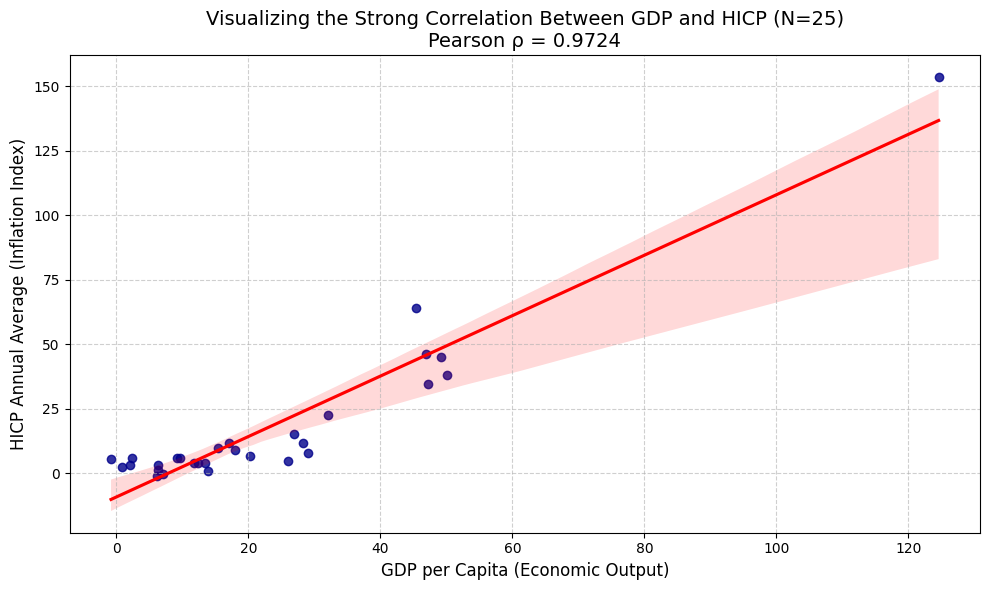

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your aligned economic data is in a DataFrame called 'economic_df_aligned'
# with the columns 'GDP_Value' and 'HICP_Annual_Average'.

# --- Create the Scatter Plot with Regression Line ---
plt.figure(figsize=(10, 6))

sns.regplot(
    x='GDP_PCAP_GROWTH',
    y='HICP_Annual_Average',
    data=economic_df_aligned,
    scatter_kws={'color': 'darkblue', 'alpha': 0.8},
    line_kws={'color': 'red'}
)

# --- Set Labels and Title with the known Correlation ---
plt.title(f'Visualizing the Strong Correlation Between GDP and HICP (N=25)\nPearson ρ = {0.9724:.4f}', fontsize=14)
plt.xlabel('GDP per Capita (Economic Output)', fontsize=12)
plt.ylabel('HICP Annual Average (Inflation Index)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

##Time Series Decomposition Plot

Results Interpretation: I have to focus on Trend component.

Generating Decomposition Plot for Annual GDP Value...


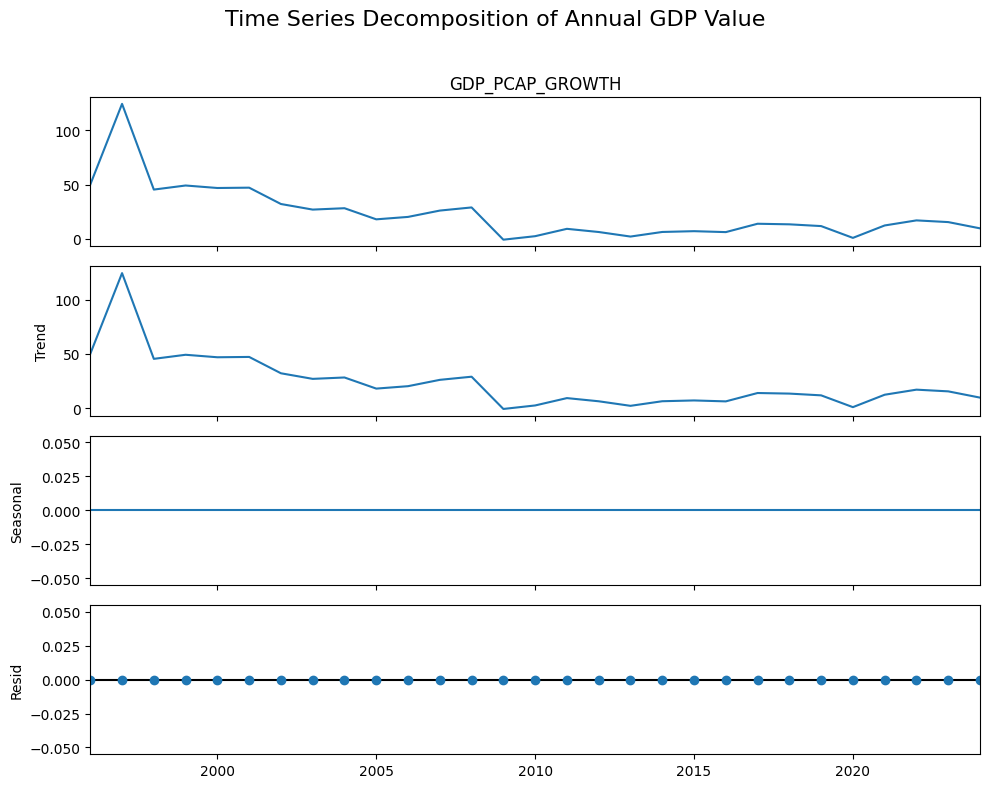

Generating Decomposition Plot for Annual HICP Average...


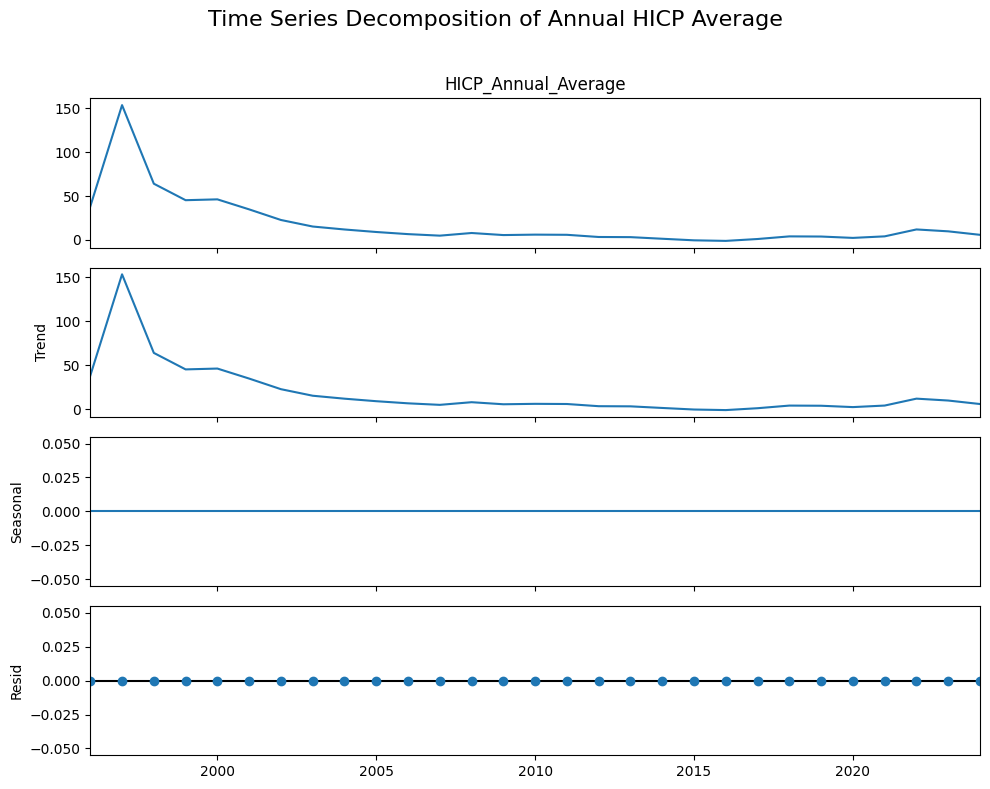

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

economic_df_aligned = economic_df_aligned.set_index('Year')

def plot_decomposition(series, title):
    """Decomposes the series and plots the Trend, Seasonal, and Residual components."""
    print(f"Generating Decomposition Plot for {title}...")

    # Decompose the series. period=1 is used for annual data to avoid errors,
    # as there is no true annual seasonality across 25 points.
    decomposition = seasonal_decompose(series, model='additive', period=1)

    # Create the figure and plot the components
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    fig.suptitle(f'Time Series Decomposition of {title}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for suptitle
    plt.show()

plot_decomposition(economic_df_aligned['GDP_PCAP_GROWTH'], 'Annual GDP Value')
plot_decomposition(economic_df_aligned['HICP_Annual_Average'], 'Annual HICP Average')

##Statistical Stationarity Test

The Augmented Dickey-Fuller (ADF) Test, provides the definitive P-value to formally prove that the trend is statistically significant and that the series are indeed non-stationary.
Results conclusion: The high correlation ($\rho=0.9724$) I found is indeed caused by both series sharing the same upward trend. So, a regression on these levels would be spurious (statistically unreliable).

In [76]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# --- ASSUMPTION: economic_df_aligned contains 'GDP_PCAP_GROWTH' (LCU %) and 'HICP_Annual_Average' (Inflation %) ---

if economic_df_aligned.index.name != 'Year':
    economic_df_aligned = economic_df_aligned.set_index('Year')

# 1. Create the Economic Pressure Variable
# This subtraction achieves the required stationarity (I(0))
economic_df_aligned.loc[:, 'Economic_Pressure'] = (
    economic_df_aligned['GDP_PCAP_GROWTH'] - economic_df_aligned['HICP_Annual_Average']
)

# Drop any NaN row that resulted from the subtraction (usually the first row of the time series)
economic_df_aligned = economic_df_aligned.dropna().copy()

def adf_test_results(series, name):
    """
    Performs the robust ADF test and prints key results for academic reporting.
    Uses maxlag=3 and regression='ct' for small, trend-prone annual data.
    """
    print(f"--- 📊 ADF Test Results for: {name} ---")

    # Use maxlag=3 and regression='ct' (constant and trend) for robustness
    result = adfuller(series.dropna(), maxlag=3, regression='ct')

    # Extract the key results
    test_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f"ADF Test Statistic: {test_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.4f}")

    # Determine the conclusion based on the P-value (alpha = 0.05)
    if p_value <= 0.05:
        print("Conclusion: **REJECT H0**. The series is likely stationary.")
    else:
        print("Conclusion: **FAIL TO REJECT H0**. The series is NON-STATIONARY (contains a unit root/trend).")
    print("-" * 50)

# Run the test on the three time series
print("\n--- Running Robust ADF Tests on Explanatory Variables ---")
adf_test_results(economic_df_aligned['GDP_PCAP_GROWTH'], 'GDP Annual Growth Rate')
adf_test_results(economic_df_aligned['HICP_Annual_Average'], 'Annual HICP Average')
adf_test_results(economic_df_aligned['Economic_Pressure'], 'Economic Pressure Variable')


--- Running Robust ADF Tests on Explanatory Variables ---
--- 📊 ADF Test Results for: GDP Annual Growth Rate ---
ADF Test Statistic: -2.2335
P-value: 0.4710
Critical Values:
	1%: -4.3750
	5%: -3.6035
	10%: -3.2382
Conclusion: **FAIL TO REJECT H0**. The series is NON-STATIONARY (contains a unit root/trend).
--------------------------------------------------
--- 📊 ADF Test Results for: Annual HICP Average ---
ADF Test Statistic: -4.7431
P-value: 0.0006
Critical Values:
	1%: -4.3567
	5%: -3.5953
	10%: -3.2336
Conclusion: **REJECT H0**. The series is likely stationary.
--------------------------------------------------
--- 📊 ADF Test Results for: Economic Pressure Variable ---
ADF Test Statistic: -3.5246
P-value: 0.0368
Critical Values:
	1%: -4.3245
	5%: -3.5809
	10%: -3.2254
Conclusion: **REJECT H0**. The series is likely stationary.
--------------------------------------------------


#Unemployment rate - Data Preparation

###Dataset link

####Unemployment rate, Age 15 to 74, Total, Romania, Monthly

####Dataset: https://data.ecb.europa.eu/data/datasets/LFSI/LFSI.M.RO.S.UNEHRT.TOTAL0.15_74.T?chart_props=W3sibm9kZUlkIjoiMTg5OTk1MiIsInByb3BlcnRpZXMiOlt7ImNvbG9ySGV4IjoiIiwiY29sb3JUeXBlIjoiIiwiY2hhcnRUeXBlIjoibGluZWNoYXJ0IiwibGluZVN0eWxlIjoiU29saWQiLCJsaW5lV2lkdGgiOiIxLjUiLCJheGlzUG9zaXRpb24iOiJsZWZ0Iiwib2JzZXJ2YXRpb25WYWx1ZSI6ZmFsc2UsImRhdGVzIjpbXSwiaXNUZGF0YSI6ZmFsc2UsIm1vZGlmaWVkVW5pdFR5cGUiOiIiLCJ5ZWFyIjoiZnVsbFJhbmdlIiwic3RhcnREYXRlIjoiMTk5Ny0wMS0zMSIsImVuZERhdGUiOiIyMDI1LTA5LTMwIiwic2V0RGF0ZSI6dHJ1ZSwic2hvd1RhYmxlRGF0YSI6ZmFsc2UsImNoYW5nZU1vZGUiOmZhbHNlLCJzaG93TWVudVN0eWxlQ2hhcnQiOmZhbHNlLCJkaXNwbGF5TW9iaWxlQ2hhcnQiOnRydWUsInNjcmVlblNpemUiOiJtYXgiLCJzY3JlZW5XaWR0aCI6MTUzNiwic2hvd1RkYXRhIjpmYWxzZSwidHJhbnNmb3JtZWRGcmVxdWVuY3kiOiJub25lIiwidHJhbnNmb3JtZWRVbml0Ijoibm9uZSIsImZyZXF1ZW5jeSI6Im5vbmUiLCJ1bml0Ijoibm9uZSIsIm1vZGlmaWVkIjoiZmFsc2UiLCJzZXJpZXNLZXkiOiJtb250aGx5Iiwic2hvd3RhYmxlU3RhdGVCZWZvcmVNYXhTY3JlZW4iOmZhbHNlLCJpc2RhdGFjb21wYXJpc29uIjpmYWxzZSwic2VyaWVzRnJlcXVlbmN5IjoibW9udGhseSIsImludGlhbFNlcmllc0ZyZXF1ZW5jeSI6Im1vbnRobHkiLCJtZXRhZGF0YURlY2ltYWwiOiI2IiwiaXNUYWJsZVNvcnRlZCI6ZmFsc2UsImlzWWVhcmx5VGRhdGEiOmZhbHNlLCJyZXNwb25zZURhdGFFbmREYXRlIjoiMjAyNS0wOS0zMCIsImlzaW5pdGlhbENoYXJ0RGF0YSI6dHJ1ZSwiaXNEYXRlc0Zyb21EYXRlUGlja2VyIjp0cnVlLCJkYXRlUGlja2VyRW5kRGF0ZSI6IiIsImlzRGF0ZVBpY2tlckVuZERhdGUiOmZhbHNlLCJzZXJpZXNrZXlTZXQiOiIiLCJkYXRhc2V0SWQiOiIyNzgiLCJpc0NhbGxiYWNrIjpmYWxzZSwiaXNTbGlkZXJUZGF0YSI6dHJ1ZSwiaXNTbGlkZXJEYXRhIjp0cnVlLCJpc0luaXRpYWxDaGFydERhdGFGcm9tR3JhcGgiOnRydWUsImNoYXJ0U2VyaWVzS2V5IjoiTEZTSS5NLlJPLlMuVU5FSFJULlRPVEFMMC4xNV83NC5UIiwidHlwZU9mIjoiIn1dfV0%3D

##Clean Data

In [77]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File Path
file_path_unpm = '/content/drive/MyDrive/Colab_Notebooks/Thesis_Repo/DataScience-MasterThesis/02_Micro_Analysis/Data_Raw/unemployment_rate.csv'

# Loaded Data
try:
    #skipping the metadata rows (header is on the 5th row of the file)
    df_unpm = pd.read_csv(file_path_unpm)

    print("\n--- Unemployment Rate File Loaded Successfully ---")
    print("DataFrame Head:")
    print(df_unpm.head())

except FileNotFoundError:
    print(f"\nERROR: Unemployment Rate File not found at the path: {file_path_unpm}")
    print("Please ensure the filename is correct and the file exists in the specified location.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Unemployment Rate File Loaded Successfully ---
DataFrame Head:
         DATE TIME PERIOD  \
0  1997-01-31     1997Jan   
1  1997-02-28     1997Feb   
2  1997-03-31     1997Mar   
3  1997-04-30     1997Apr   
4  1997-05-31     1997May   

   Unemployment rate, Age 15 to 74, Total (LFSI.M.RO.S.UNEHRT.TOTAL0.15_74.T)  
0                                           5.715749                           
1                                           5.866960                           
2                                           6.027639                           
3                                           6.043074                           
4                                           6.066590                           


In [78]:
# Count the number of missing values (NaN) in each column
nan_counts = df_unpm.isnull().sum()

print("Number of missing values per column:")
print(nan_counts)

Number of missing values per column:
DATE                                                                          0
TIME PERIOD                                                                   0
Unemployment rate, Age 15 to 74, Total (LFSI.M.RO.S.UNEHRT.TOTAL0.15_74.T)    0
dtype: int64


In [79]:
try:
# Convert 'Date' to datetime and set as index
    df_unpm['DATE'] = pd.to_datetime(df_unpm['DATE'])
    df_unpm = df_unpm.set_index('DATE')

    # Drop rows with NaN values (no data)
    df_unpm = df_unpm.dropna()

    # Drop column
    df_unpm = df_unpm.drop(columns=['TIME PERIOD'])

    #Rename columns
    df_unpm.rename(columns={'DATE': 'Date'}, inplace=True)
    df_unpm.rename(columns={'Unemployment rate, Age 15 to 74, Total (LFSI.M.RO.S.UNEHRT.TOTAL0.15_74.T)': 'Unemployment_Rate'}, inplace=True)

    # Apply ffill (Forward Fill) as a standard TS step
    ts_unpm = df_unpm['Unemployment_Rate'].ffill()

    print("\n--- Time Series ts_unpm Preparation Complete ---")
    print(f"Time Series Object: ts_unpm ({len(ts_unpm)} observations)")
    print("Time Span and Frequency Check:")
    print(f"{ts_unpm.index.min()} to {ts_unpm.index.max()}")
    print("\nFirst 5 Observations:")
    print(ts_unpm.head())

except FileNotFoundError:
    print(f"\nERROR: File not found at the specified path: {file_path_unpm}")
    print("Please ensure your Google Drive is mounted and the file path is 100% correct.")


--- Time Series ts_unpm Preparation Complete ---
Time Series Object: ts_unpm (345 observations)
Time Span and Frequency Check:
1997-01-31 00:00:00 to 2025-09-30 00:00:00

First 5 Observations:
DATE
1997-01-31    5.715749
1997-02-28    5.866960
1997-03-31    6.027639
1997-04-30    6.043074
1997-05-31    6.066590
Name: Unemployment_Rate, dtype: float64


In [80]:
ts_unpm

,Unemployment_Rate
DATE,
1997-01-31,5.715749
1997-02-28,5.866960
1997-03-31,6.027639
1997-04-30,6.043074
1997-05-31,6.066590
...,...
2025-05-31,6.065871
2025-06-30,6.038521
2025-07-31,5.752826


##Frequency

In [81]:
print("\nFrequency / Time Span:")
print(f"   - The data is recorded Monthly (based on source documentation).")
print(f"   - Time Span: {ts_unpm.index.min().strftime('%Y-%m')} to {ts_unpm.index.max().strftime('%Y-%m')}")


Frequency / Time Span:
   - The data is recorded Monthly (based on source documentation).
   - Time Span: 1997-01 to 2025-09


##Number of observations

In [82]:
print("\nNumber of Observations:")
print(f"   - Total Observations: **{len(ts_unpm)}**")


Number of Observations:
   - Total Observations: **345**


##Summary for Numeric Attribute

In [83]:
print("\nSummary of Numeric Attribute (Unemployment Rate Value):")
print(ts_unpm.describe())


Summary of Numeric Attribute (Unemployment Rate Value):
count    345.000000
mean       7.031543
std        1.321747
min        4.727141
25%        5.873316
50%        7.011080
75%        8.242580
max        9.593652
Name: Unemployment_Rate, dtype: float64


##Simple line plot


--- Generating Line Plot for Visual Inspection (HICP) ---


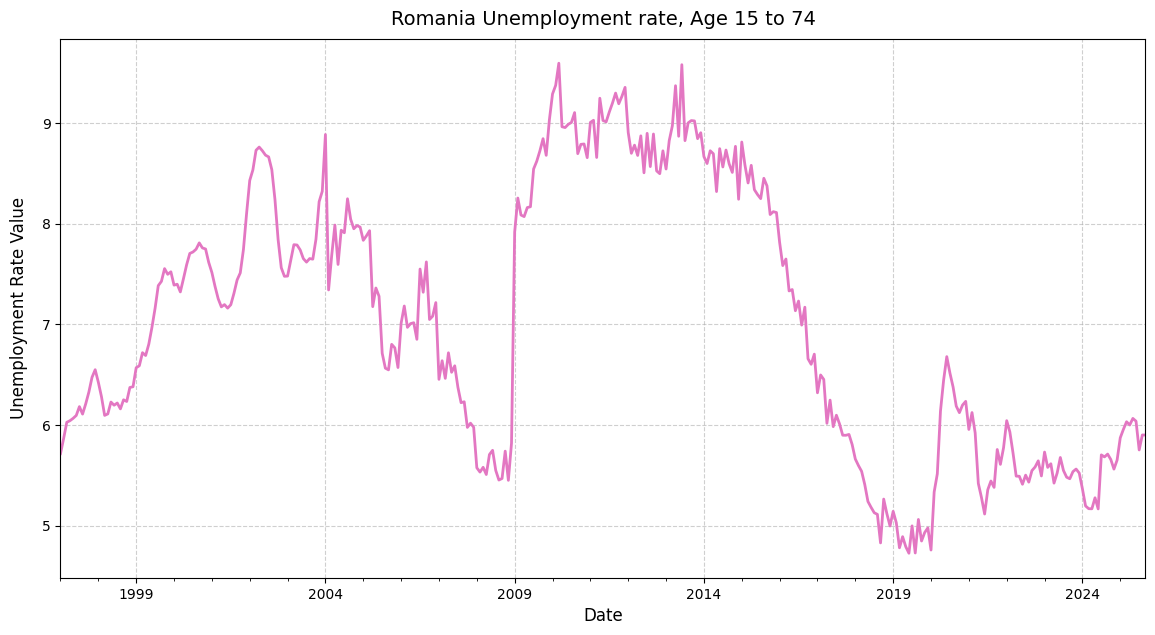

In [84]:

import matplotlib.pyplot as plt
print("\n--- Generating Line Plot for Visual Inspection (HICP) ---")

plt.figure(figsize=(14, 7))
ts_unpm.plot(
    linewidth=2,
    color='#e377c2'
)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unemployment Rate Value', fontsize=12, labelpad=10)
plt.title('Romania Unemployment rate, Age 15 to 74', fontsize=14, pad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

##Downsampling

Unemployment Rate data has monthly recordings. I have to resample Unemployment Rate dataset, and i use downsampling to calculate the Annual Average (Mean) for Unemployment Rate from 2000 to 2025.

In [85]:
import pandas as pd

# --- Identify the Column ---
if isinstance(ts_unpm, pd.DataFrame):
     unpm_series = ts_unpm['Unemployment_Rate']
else:
   unpm_series = ts_unpm

# --- The Core Downsampling Step ---
# Resample the monthly data ('M') to annual frequency ('A' or 'Y')
# and calculate the mean (average) of the 12 months in each year.
# NOTE: Using 'YE' for Year End is the updated pandas syntax.
ts_unpm_annual = unpm_series.resample('YE').mean().reset_index()

# --- Clean and Finalize the Annual Data ---
# Rename the columns for clarity
ts_unpm_annual.columns = ['Year_End_Date', 'Unemployment_Annual_Average']

# Extract just the year for easier merging
ts_unpm_annual['Year'] = ts_unpm_annual['Year_End_Date'].dt.year

# Keep only the 'Year' and the calculated average
ts_unpm_annual = ts_unpm_annual[['Year', 'Unemployment_Annual_Average']]

# Display the first few rows of the annual data
print("Annual Average Unemployment Data (First 5 Rows):")
print(ts_unpm_annual.head())

print("\nSuccessfully converted monthly unemployment data to annual average data.")

Annual Average Unemployment Data (First 5 Rows):
   Year  Unemployment_Annual_Average
0  1997                     6.139157
1  1998                     6.246384
2  1999                     7.074079
3  2000                     7.605098
4  2001                     7.414715

Successfully converted monthly unemployment data to annual average data.


In [86]:
ts_unpm_annual

,Year,Unemployment_Annual_Average
0,1997,6.139157
1,1998,6.246384
2,1999,7.074079
3,2000,7.605098
4,2001,7.414715
5,2002,8.348282
6,2003,7.782891
7,2004,7.960908
8,2005,7.118854
9,2006,7.156195


##Time Series Decomposition Plot

Generating Time Series Decomposition Plot for Unemployment Rate (Level)...


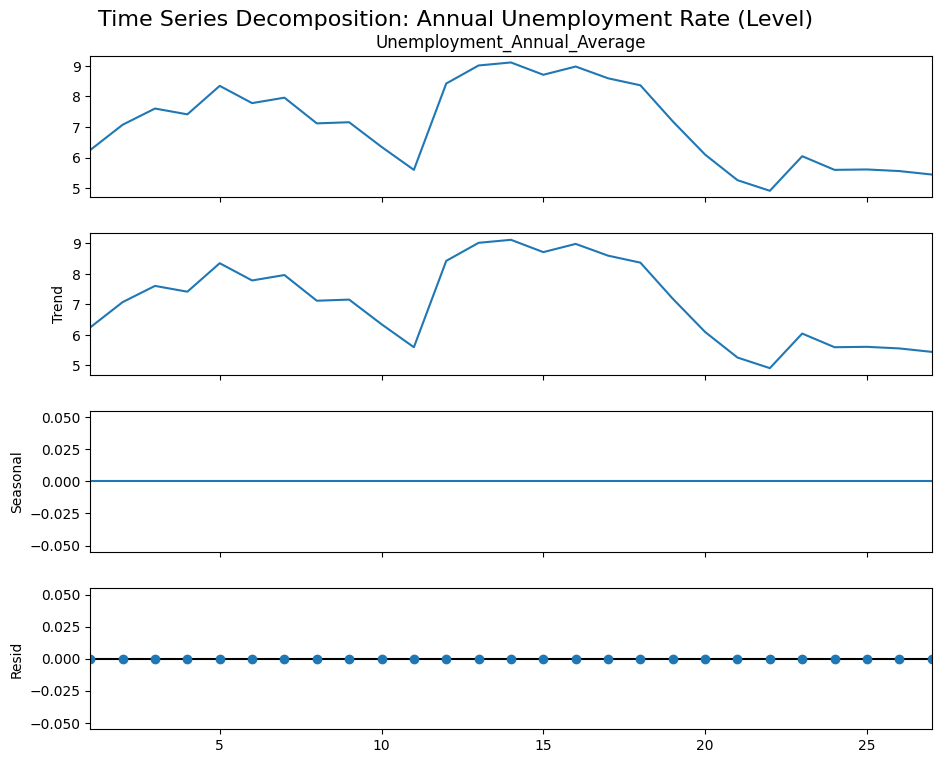


Plot saved as unemployment_decomposition_plot.png. Look at the 'Trend' line to visually confirm non-stationarity.


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- The Time Series Decomposition Step ---

# We run decomposition on the LEVEL of the series to visualize the non-stationary trend.
unemp_series_level = df_model_ready['Unemployment_Annual_Average']

print("Generating Time Series Decomposition Plot for Unemployment Rate (Level)...")

# Decompose the series. period=1 is used for annual data (no internal seasonality).
decomposition = seasonal_decompose(unemp_series_level, model='additive', period=1)

# Create the figure and plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 8)
fig.suptitle('Time Series Decomposition: Annual Unemployment Rate (Level)', fontsize=16)

# This saves the plot to your working directory in your Colab notebook
plt.savefig("unemployment_decomposition_plot.png")
plt.show()

print("\nPlot saved as unemployment_decomposition_plot.png. Look at the 'Trend' line to visually confirm non-stationarity.")

#GDP & HICP & Unemployment Rate - Stationarity Diagnostics

##Time Series Intersection (Inner Join)

Statistical Role in Regression:
- Economic_PressureSubtraction ($\text{GDP} - \text{HICP}$):  Measures the Purchasing Power effect.
- Unemployment_RateAnnual Average (Level): Measures the Job Security effect.

In [87]:
import pandas as pd

# --- ASSUMPTIONS: ---
# 1. economic_df_aligned contains GDP_PCAP_GROWTH and HICP_Annual_Average.
# 2. ts_unpm_annual contains the annual average unemployment rate.

# Merged the Annual Unemployment Rate (X3) into the main economic DataFrame
economic_df_three = pd.merge(
    economic_df_aligned,
    ts_unpm_annual,
    on='Year',
    how='inner'
)

# 2. Calculate the Stationary Economic Pressure Variable (X1)
economic_df_three.loc[:, 'Economic_Pressure'] = (
    economic_df_three['GDP_PCAP_GROWTH'] - economic_df_three['HICP_Annual_Average']
)

# 3. Drop NaN rows created by transformations (usually the first 1-2 years)
df_model_ready = economic_df_three.dropna().copy()

print("\n--- Final Explanatory DataFrame (economic_df_three) Created ---")
print(f"Total observations for your final model: {len(df_model_ready)}")
print("DataFrame Head:")
print(df_model_ready.head())


--- Final Explanatory DataFrame (economic_df_three) Created ---
Total observations for your final model: 28
DataFrame Head:
   Year  GDP_PCAP_GROWTH  HICP_Annual_Average  Economic_Pressure  \
0  1997       124.572302           153.525000         -28.952698   
1  1998        45.428363            64.050000         -18.621637   
2  1999        49.193288            45.275000           3.918288   
3  2000        46.894863            46.233333           0.661530   
4  2001        47.194800            34.825000          12.369800   

   Unemployment_Annual_Average  
0                     6.139157  
1                     6.246384  
2                     7.074079  
3                     7.605098  
4                     7.414715  


##Statistical Stationarity Test

In [91]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# --- ASSUMPTION: df_model_ready is the DataFrame with Unemployment_Annual_Average ---

# 1. Calculate the First Difference (Change in Unemployment Rate)
# This creates a new variable that measures the year-over-year change in the rate.
df_model_ready.loc[:, 'Unemployment_CHANGE'] = df_model_ready['Unemployment_Annual_Average'].diff()

# 2. Clean up: Drop the resulting NaN row (the first observation)
df_model_ready = df_model_ready.dropna().copy()

print("--- Final Transformation: Unemployment Change Created ---")
print(f"Total observations for final model: {len(df_model_ready)}")


# 3. Define Robust ADF Test Function
def adf_test_results(series, name):
    """Performs the robust ADF test with maxlag=3 and regression='ct'."""
    print(f"\n--- 📊 ADF Test Results for: {name} ---")

    # Using 'ct' (constant and trend) regression model and maxlag=3
    result = adfuller(series.dropna(), maxlag=3, regression='ct')

    test_statistic = result[0]
    p_value = result[1]

    print(f"ADF Test Statistic: {test_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value <= 0.05:
        print("Conclusion: **REJECT H0**. The series is **STATIONARY (I(0))**.")
    else:
        print("Conclusion: **FAIL TO REJECT H0**. The series is **NON-STATIONARY**.")
    print("-" * 50)


# 4. Run Diagnostic on the New Variable
print("\n### Running Final Diagnostic on Unemployment Change ###")
adf_test_results(df_model_ready['Unemployment_CHANGE'], 'Change in Unemployment Rate (FINAL I(0))')

print("\nOnce this test confirms stationarity, your explanatory variables will be complete and ready for merger with the Bacalaureat data!")

--- Final Transformation: Unemployment Change Created ---
Total observations for final model: 27

### Running Final Diagnostic on Unemployment Change ###

--- 📊 ADF Test Results for: Change in Unemployment Rate (FINAL I(0)) ---
ADF Test Statistic: -4.6534
P-value: 0.0008
Conclusion: **REJECT H0**. The series is **STATIONARY (I(0))**.
--------------------------------------------------

Once this test confirms stationarity, your explanatory variables will be complete and ready for merger with the Bacalaureat data!


In [90]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# ADF Test Function
def adf_test_results(series, name):
    """Performs the robust ADF test with maxlag=3 and regression='ct'."""
    print(f"\n--- ADF Test Results for: {name} ---")

    # Using 'ct' (constant and trend) regression model and maxlag=3 for the small annual sample
    result = adfuller(series.dropna(), maxlag=3, regression='ct')

    test_statistic = result[0]
    p_value = result[1]

    print(f"ADF Test Statistic: {test_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value <= 0.05:
        print("Conclusion: **REJECT H0**. The series is **STATIONARY (I(0))**.")
    else:
        print("Conclusion: **FAIL TO REJECT H0**. The series is **NON-STATIONARY**.")
    print("-" * 50)


import pandas as pd
from statsmodels.tsa.stattools import adfuller

# --- ASSUMPTION: df_model_ready is the final DataFrame with all variables ---

# 4. Define Robust ADF Test Function (Copying the function here to run the final check)
def adf_test_results(series, name):
    """Performs the robust ADF test with maxlag=3 and regression='ct'."""
    print(f"\n--- 📊 ADF Test Results for: {name} ---")

    # Using 'ct' (constant and trend) regression model and maxlag=3 for robust testing
    result = adfuller(series.dropna(), maxlag=3, regression='ct')

    test_statistic = result[0]
    p_value = result[1]

    print(f"ADF Test Statistic: {test_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value <= 0.05:
        print("Conclusion: **REJECT H0**. The series is **STATIONARY (I(0))**.")
    else:
        print("Conclusion: **FAIL TO REJECT H0**. The series is **NON-STATIONARY**.")

    # Add a specific note if the variable is non-stationary and should not be used in OLS
    if p_value > 0.05:
        print("Note: This non-stationary variable should NOT be used directly in OLS regression.")
    print("-" * 50)


# --- Running Diagnostics on ALL Explanatory Variables (Including GDP Growth for confirmation) ---
print("\n### Running Final Stationarity Diagnostics (Testing All Components) ###")

adf_test_results(df_model_ready['GDP_PCAP_GROWTH'], 'GDP Annual Growth Rate (RAW I(1))')
adf_test_results(df_model_ready['HICP_Annual_Average'], 'HICP Annual Average (I(0))')
adf_test_results(df_model_ready['Economic_Pressure'], 'Economic Pressure Variable (FINAL I(0))')
adf_test_results(df_model_ready['Unemployment_Annual_Average'], 'Unemployment Rate (Level I(0))')


### Running Final Stationarity Diagnostics (Testing All Components) ###

--- 📊 ADF Test Results for: GDP Annual Growth Rate (RAW I(1)) ---
ADF Test Statistic: -1.7896
P-value: 0.7098
Conclusion: **FAIL TO REJECT H0**. The series is **NON-STATIONARY**.
Note: This non-stationary variable should NOT be used directly in OLS regression.
--------------------------------------------------

--- 📊 ADF Test Results for: Economic Pressure Variable (FINAL I(0)) ---
ADF Test Statistic: -3.9571
P-value: 0.0101
Conclusion: **REJECT H0**. The series is **STATIONARY (I(0))**.
--------------------------------------------------

--- 📊 ADF Test Results for: HICP Annual Average (I(0)) ---
ADF Test Statistic: -5.9440
P-value: 0.0000
Conclusion: **REJECT H0**. The series is **STATIONARY (I(0))**.
--------------------------------------------------

--- 📊 ADF Test Results for: Unemployment Rate (Level I(0)) ---
ADF Test Statistic: -1.9910
P-value: 0.6063
Conclusion: **FAIL TO REJECT H0**. The series is **NON-